In [ ]:

import kagglehub
abhinavwalia95_entity_annotated_corpus_path = kagglehub.dataset_download('abhinavwalia95/entity-annotated-corpus')

print('Data source import complete.')


100%|██████████| 26.4M/26.4M [00:00<00:00, 59.9MB/s]

Extracting files...


Data source import complete.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

# Named Entity Recognition (NER)

NER is an information extraction technique to identify and classify named entities in text. These entities can be pre-defined and generic like location names, organizations, time and etc, or they can be very specific like the example with the resume.

The goal of a named entity recognition (NER) system is to identify all textual mentions of the named entities. This can be broken down into two sub-tasks: identifying the boundaries of the NE, and identifying its type.

Named entity recognition is a task that is well-suited to the type of classifier-based approach. In particular, a tagger can be built that labels each word in a sentence using the IOB format, where chunks are labelled by their appropriate type.

The IOB Tagging system contains tags of the form:

* B - {CHUNK_TYPE} – for the word in the Beginning chunk
* I - {CHUNK_TYPE} – for words Inside the chunk
* O – Outside any chunk

The IOB tags are further classified into the following classes –

* geo = Geographical Entity
* org = Organization
* per = Person
* gpe = Geopolitical Entity
* tim = Time indicator
* art = Artifact
* eve = Event
* nat = Natural Phenomenon

**Deep Learning Approaches:** Bidirectional RNNs

# EDA

In [ ]:
data = pd.read_csv("ner.csv", encoding = "ISO-8859-1",usecols=['sentence_idx', 'word', 'tag'])
data  = data[data['sentence_idx'] != 'prev-lemma'].dropna(subset=['sentence_idx']).reset_index(drop=True)
print(data.shape)
data.head()

<ipython-input-6-6a818056ce4e>:1: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("ner.csv", encoding = "ISO-8859-1",usecols=['sentence_idx', 'word', 'tag'])


(514850, 3)


,sentence_idx,word,tag
0,1,Thousands,O
1,1,of,O
2,1,demonstrators,O
3,1,have,O
4,1,marched,O


**Create list of list of tuples to differentiate each sentence from each other**

In [ ]:
class SentenceGetter(object):

    def __init__(self, dataset, word_col, tag_col, sent_id_col):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [
            (w, t) for w,t in zip(s[word_col].values.tolist(), s[tag_col].values.tolist())
        ]
        self.grouped = self.dataset.groupby(sent_id_col).apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [ ]:
getter = SentenceGetter(dataset=data, word_col='word', tag_col='tag', sent_id_col='sentence_idx')
sentences = getter.sentences
print(sentences[0])

[('Thousands', 'O'), ('of', 'O'), ('demonstrators', 'O'), ('have', 'O'), ('marched', 'O'), ('through', 'O'), ('London', 'B-geo'), ('to', 'O'), ('protest', 'O'), ('the', 'O'), ('war', 'O'), ('in', 'O'), ('Iraq', 'B-geo'), ('and', 'O'), ('demand', 'O'), ('the', 'O'), ('withdrawal', 'O'), ('of', 'O'), ('British', 'B-gpe'), ('troops', 'O'), ('from', 'O'), ('that', 'O'), ('country', 'O'), ('.', 'O')]


<ipython-input-7-9b2f8a414776>:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.grouped = self.dataset.groupby(sent_id_col).apply(agg_func)


Number of Sentences: 13497
Maximum sequence length: 140
Number of unique words: 18520


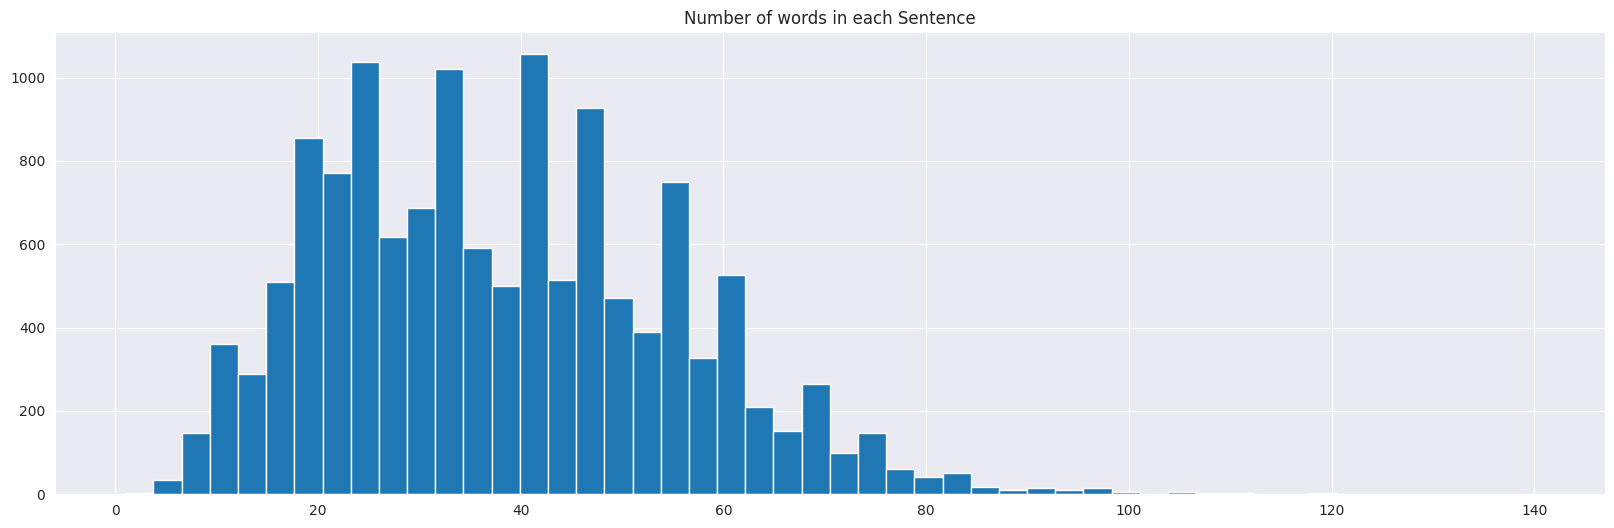

In [ ]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.hist([len(s) for s in sentences], bins=50)
ax.set_title('Number of words in each Sentence')

maxlen = max([len(s) for s in sentences])
print('Number of Sentences:', len(sentences))
print ('Maximum sequence length:', maxlen)

words = list(set(data["word"].values))
words.append("ENDPAD")
n_words = len(words)
print('Number of unique words:', n_words)

Number of unique Tags: 17


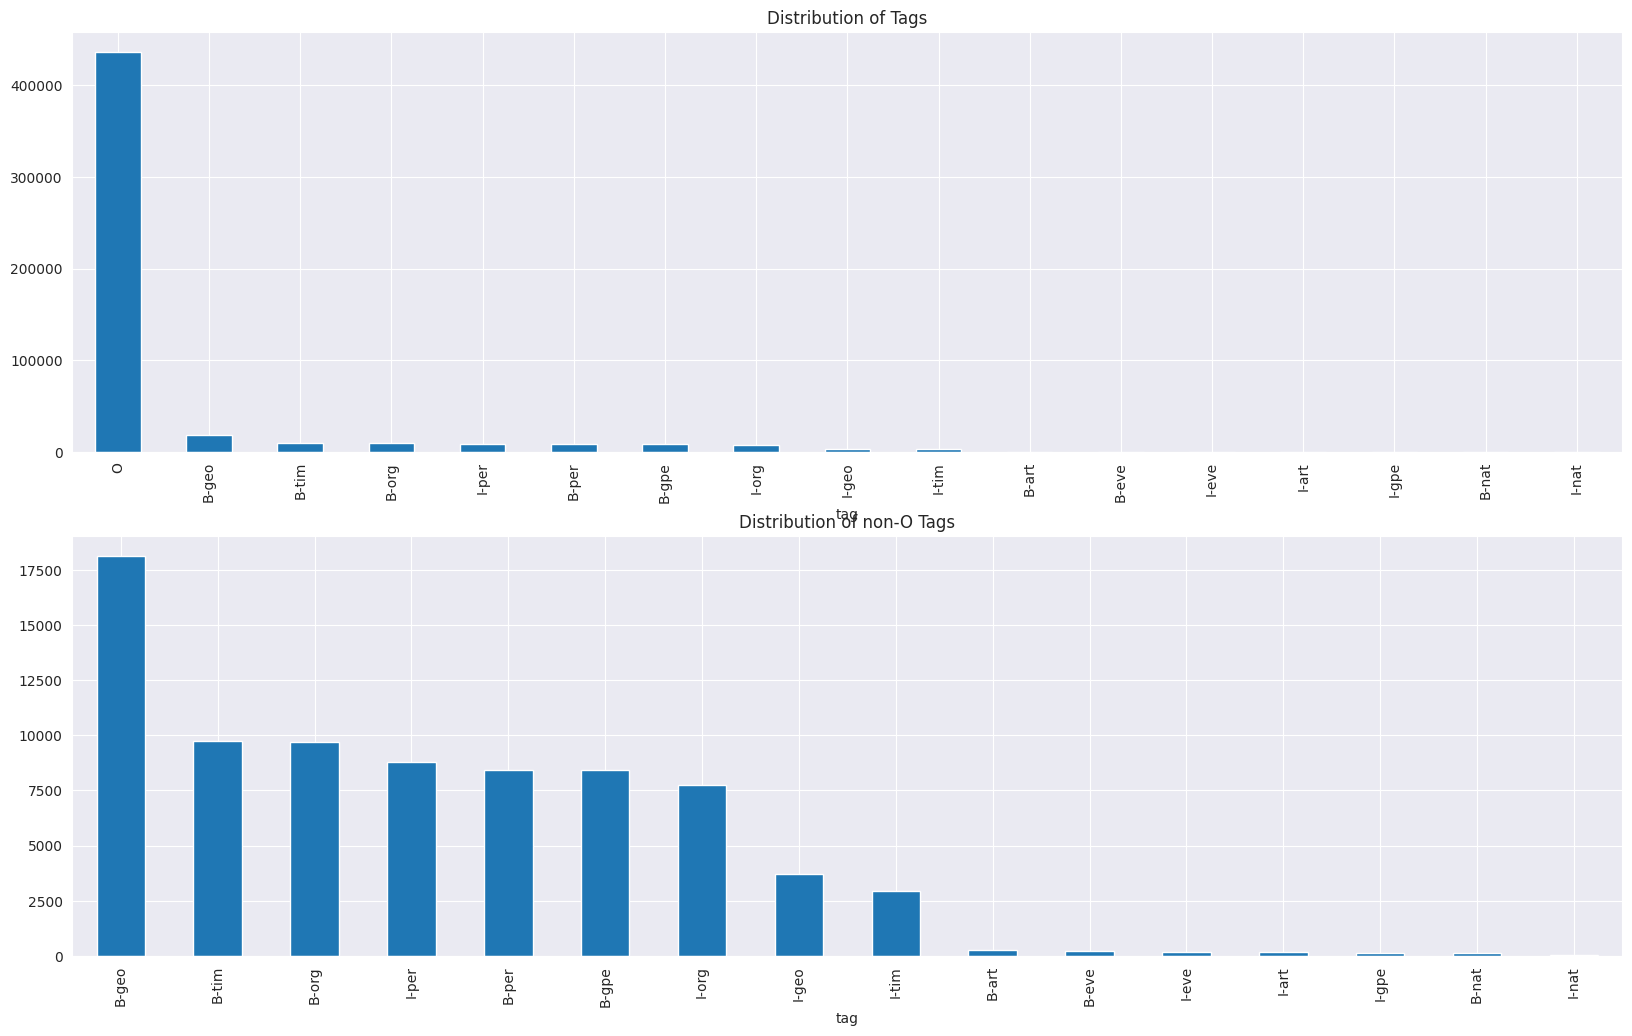

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(20, 12))
data.tag.value_counts().plot.bar(ax=ax[0], title='Distribution of Tags')
data[data.tag != 'O'].tag.value_counts().plot.bar(ax=ax[1], title='Distribution of non-O Tags')

tags = list(set(data["tag"].values))
n_tags = len(tags)
print('Number of unique Tags:', n_tags)

**Converting words to numbers and numbers to words**

In [ ]:
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

# Modelling

In [ ]:
from keras.models import Sequential
from keras.layers import Input, Embedding,TimeDistributed, LSTM, Dropout, Bidirectional, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.utils import plot_model, to_categorical

In [ ]:
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = sequence.pad_sequences(maxlen=maxlen, sequences=X, padding="post",value=n_words - 1)

y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = sequence.pad_sequences(maxlen=maxlen, sequences=y, padding="post", value=tag2idx["O"])
y = np.array([to_categorical(i, num_classes=n_tags) for i in y])

print('X shape', X.shape, 'y shape', y.shape)

X shape (13497, 140) y shape (13497, 140, 17)


In [ ]:
class config():
    VOCAB = n_words
    MAX_LEN = maxlen
    N_OUPUT = n_tags


    EMBEDDING_VECTOR_LENGTH = 50
    N_LSTM_CELLS = 64
    RECURRENT_DROPOUT = 0.1

    OUTPUT_ACTIVATION = 'softmax'

    LOSS = 'categorical_crossentropy'
    OPTIMIZER = 'adam'
    METRICS = ['accuracy']

    MAX_EPOCHS = 10


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 140, 50)             │         926,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 140, 128)            │          58,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 140, 17)             │           2,193 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 987,073 (3.77 MB)

 Trainable params: 987,073 (3.77 MB)

 Non-trainable params: 0 (0.00 B)

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


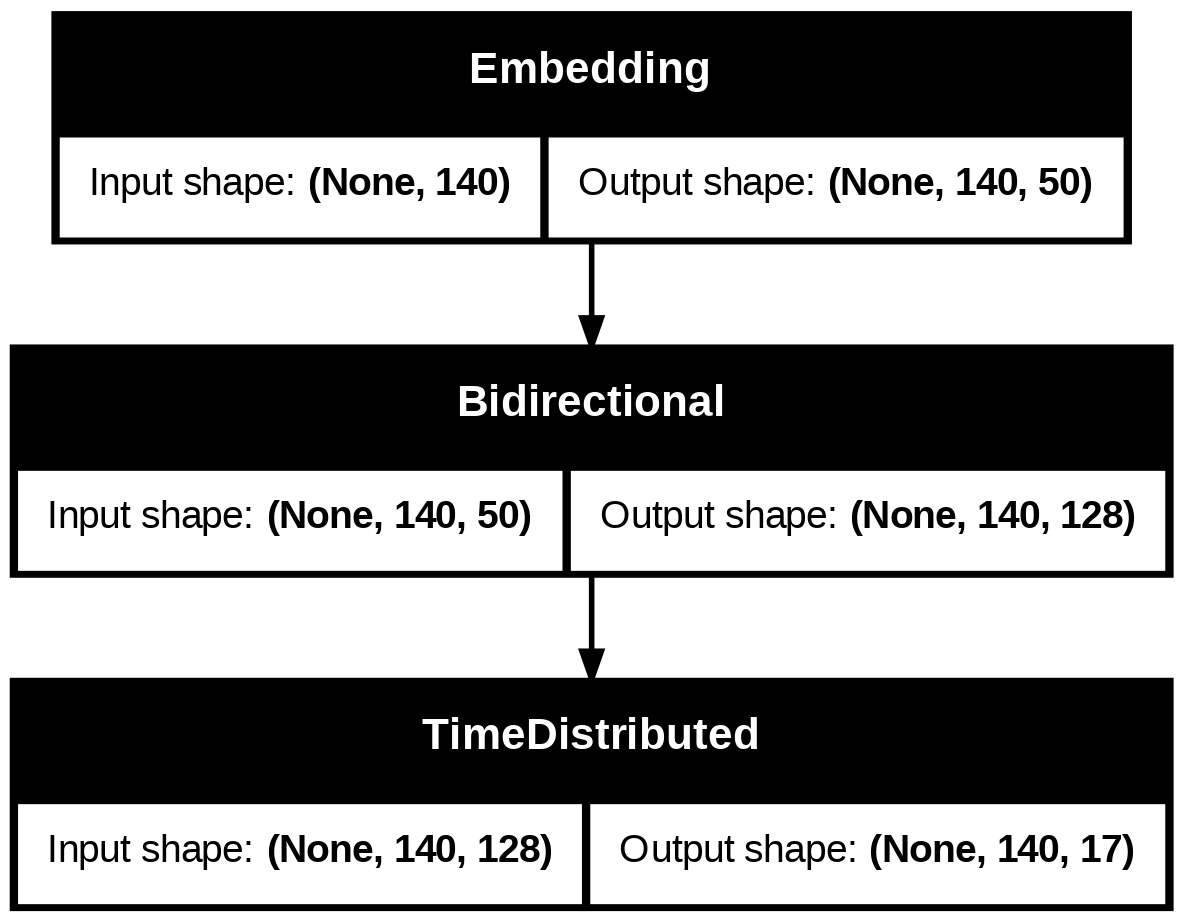

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)
filepath = "model.keras"

ckpt = ModelCheckpoint(
    filepath,
    monitor='loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)
rlp = ReduceLROnPlateau(monitor='loss', patience=3, verbose=1)

# Create the model
model = Sequential()
model.add(
    Embedding(
        input_dim=config.VOCAB,
        output_dim=config.EMBEDDING_VECTOR_LENGTH
        # Removed input_length as it's deprecated
    )
)
model.add(
    Bidirectional(
        LSTM(config.N_LSTM_CELLS, return_sequences=True, recurrent_dropout=config.RECURRENT_DROPOUT)
    )
)
model.add(
    TimeDistributed(
        Dense(config.N_OUPUT, activation=config.OUTPUT_ACTIVATION)
    )
)

# Build the model by specifying input shape
model.build(input_shape=(None, config.MAX_LEN))  # Add this line

# Compile the model
model.compile(loss=config.LOSS, optimizer=config.OPTIMIZER, metrics=config.METRICS)

# Now you can show summary and plot
model.summary()

# Make sure you have pydot and graphviz installed
!apt-get install graphviz
!pip install pydot

# Import plot_model
from tensorflow.keras.utils import plot_model

# Plot the model
plot_model(model, show_shapes=True, to_file='model_plot.png')

from IPython.display import Image
Image('model_plot.png')

In [ ]:
history = model.fit(x=X, y=y, validation_split=0.1,
    callbacks=[es, ckpt, rlp], epochs=config.MAX_EPOCHS
)

Epoch 1/10
380/380 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.9398 - loss: 0.4085
Epoch 1: loss improved from inf to 0.20904, saving model to model.keras
380/380 ━━━━━━━━━━━━━━━━━━━━ 179s 432ms/step - accuracy: 0.9398 - loss: 0.4080 - val_accuracy: 0.9818 - val_loss: 0.0591 - learning_rate: 0.0010
Epoch 2/10
380/380 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.9741 - loss: 0.0889
Epoch 2: loss improved from 0.20904 to 0.07554, saving model to model.keras
380/380 ━━━━━━━━━━━━━━━━━━━━ 192s 405ms/step - accuracy: 0.9741 - loss: 0.0889 - val_accuracy: 0.9911 - val_loss: 0.0334 - learning_rate: 0.0010
Epoch 3/10
380/380 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.9884 - loss: 0.0434
Epoch 3: loss improved from 0.07554 to 0.04111, saving model to model.keras
380/380 ━━━━━━━━━━━━━━━━━━━━ 201s 402ms/step - accuracy: 0.9884 - loss: 0.0434 - val_accuracy: 0.9926 - val_loss: 0.0267 - learning_rate: 0.0010
Epoch 4/10
380/380 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.9914 - lo

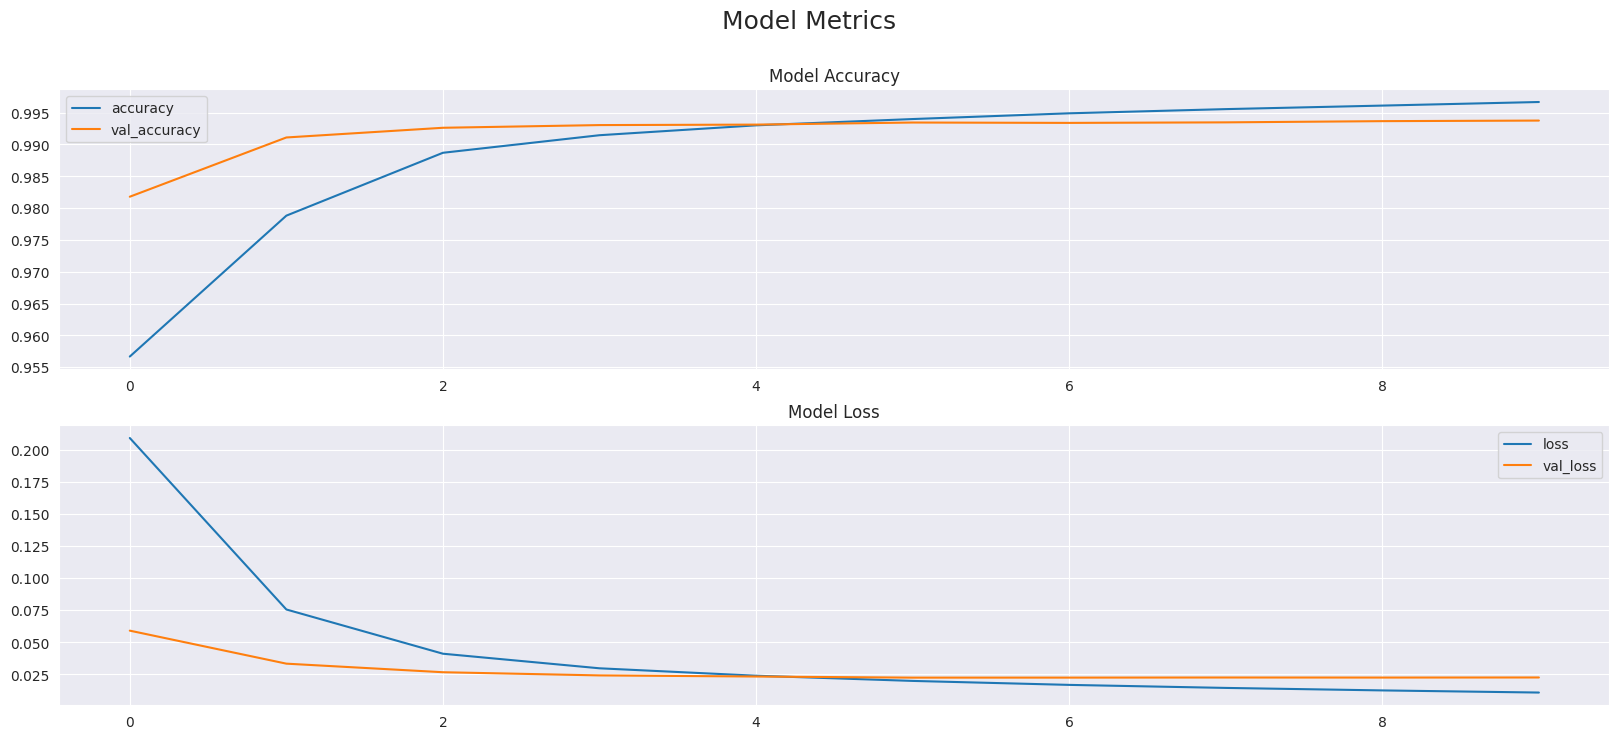

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(20, 8))
df = pd.DataFrame(history.history)
df[['accuracy', 'val_accuracy']].plot(ax=ax[0])
df[['loss', 'val_loss']].plot(ax=ax[1])
ax[0].set_title('Model Accuracy', fontsize=12)
ax[1].set_title('Model Loss', fontsize=12)
fig.suptitle('Model Metrics', fontsize=18);

In [ ]:
i = np.random.randint(0, X.shape[0])
p = model.predict(np.array([X[i]]))
p = np.argmax(p, axis=-1)
y_true = np.argmax(y, axis=-1)[i]

print(f"{'Word':15}{'True':5}\t{'Pred'}")
print("-"*30)
for (w, t, pred) in zip(X[i], y_true, p[0]):
    print(f"{words[w]:15}{tags[t]}\t{tags[pred]}")
    if words[w] == 'ENDPAD':
        break

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Word           True 	Pred
------------------------------
Mr.            B-per	B-per
Obama          I-per	I-per
has            O	O
vowed          O	O
to             O	O
sign           O	O
a              O	O
health         O	O
care           O	O
bill           O	O
into           O	O
law            O	O
this           O	O
year           O	O
.              O	O
ENDPAD         O	O
